# ezlocalai Tests and Examples

Simply choose your favorite model of choice from the models list and paste it into the `model` variable on the API calls. You can get a list of models below.

Install OpenAI and requests:

```bash
pip install openai requests python-dotenv
```

**Note, you do not need an OpenAI API Key, the API Key is your `EZLOCALAI_API_KEY` for the server if you defined one in your `.env` file.**

## Global definitions and helpers

Confirm that your `DEFAULT_MODEL` is set to the model you want to use in your `.env` file.


In [33]:
import openai
import requests
import time
import os
import re
from dotenv import load_dotenv

load_dotenv()

# Set your system message, max tokens, temperature, and top p here, or use the defaults.
SYSTEM_MESSAGE = "Act as a creative writer. All of your text responses are transcribed to audio and sent to the user. Be concise with all responses. After the request is fulfilled, end with </s>."
DEFAULT_MAX_TOKENS = 256
DEFAULT_TEMPERATURE = 1.33
DEFAULT_TOP_P = 0.95


# ------------------- DO NOT EDIT BELOW THIS LINE IN THIS CELL ------------------- #
EZLOCALAI_SERVER = os.getenv("EZLOCALAI_SERVER", "http://localhost:8091")
EZLOCALAI_API_KEY = os.getenv("EZLOCALAI_API_KEY", "none")
DEFAULT_LLM = os.getenv("DEFAULT_LLM", "zephyr-7b-beta")
openai.base_url = f"{EZLOCALAI_SERVER}/v1/"
openai.api_key = EZLOCALAI_API_KEY if EZLOCALAI_API_KEY else EZLOCALAI_SERVER
HEADERS = {
    "Content-Type": "application/json",
    "Authorization": f"{EZLOCALAI_API_KEY}",
    "ngrok-skip-browser-warning": "true",
}


def display_content(content):
    global EZLOCALAI_SERVER
    global HEADERS
    outputs_url = f"{EZLOCALAI_SERVER}/outputs/"
    try:
        from IPython.display import Audio, display, Image, Video
    except:
        print(content)
        return
    if "http://localhost:8091/outputs/" in content:
        if outputs_url != "http://localhost:8091/outputs/":
            content = content.replace("http://localhost:8091/outputs/", outputs_url)
    if "<audio controls>" in content or " " not in content:
        import base64
        from datetime import datetime

        try:
            audio_response = content.split("data:audio/wav;base64,")[1].split('" type')[
                0
            ]
        except:
            audio_response = content
        file_name = f"outputs/{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.wav"
        with open(file_name, "wb") as fh:
            fh.write(base64.b64decode(audio_response))
        display(Audio(filename=file_name, autoplay=True))
    if outputs_url in content:
        urls = re.findall(f"{re.escape(outputs_url)}[^\"' ]+", content)
        for url in urls:
            file_name = url.split("/")[-1]
            url = f"{outputs_url}{file_name}"
            data = requests.get(url, headers=HEADERS).content
            if url.endswith(".jpg") or url.endswith(".png"):
                content = content.replace(url, "")
                display(Image(data=data))
            if url.endswith(".mp4"):
                content = content.replace(url, "")
                display(Video(data=data, autoplay=True))
            if url.endswith(".wav"):
                content = content.replace(url, "")
                print(f"URL: {url}")
                display(Audio(data=data, autoplay=True))
    print(content)

## Language Models

Get a list of models to choose from if you don't already know what model you want to use.


In [21]:
# Wait for server to come up instead of timing out.
while True:
    try:
        models = requests.get(f"{EZLOCALAI_SERVER}/v1/models", headers=HEADERS)
        if models.status_code == 200:
            break
    except:
        pass
    time.sleep(1)

print(models.json())

['bakllava-1-7b', 'llava-v1.5-7b', 'llava-v1.5-13b', 'yi-vl-6b', 'CapybaraHermes-2.5-Mistral-7B', 'CapybaraHermes-2.5-Mistral-7B', 'KafkaLM-70B-German-V0.1', 'CodeLlama-70B-Python', 'CodeLlama-70B-Instruct', 'CodeLlama-70B-hf', 'Tess-34B-v1.5b', 'Tess-10.7B-v1.5b', 'Goliath-longLORA-120b-rope8-32k-fp16', 'Etheria-55b-v0.1', 'EstopianMaid-13B', 'Everyone-Coder-33B-Base', 'FusionNet_34Bx2_MoE', 'WestLake-7B-v2', 'WestSeverus-7B-DPO', 'DiscoLM_German_7b_v1', 'Garrulus', 'DareVox-7B', 'NexoNimbus-7B', 'Lelantos-Maid-DPO-7B', 'stable-code-3b', 'Dr_Samantha-7B', 'NeuralBeagle14-7B', 'tigerbot-13B-chat-v5', 'Nous-Hermes-2-Mixtral-8x7B-SFT', 'Thespis-13B-DPO-v0.7', 'Code-290k-13B', 'Nous-Hermes-2-Mixtral-8x7B-DPO', 'Venus-120b-v1.2', 'LLaMA2-13B-Estopia', 'medicine-LLM', 'finance-LLM-13B', 'Yi-34B-200K-DARE-megamerge-v8', 'phi-2-orange', 'laser-dolphin-mixtral-2x7b-dpo', 'bagel-dpo-8x7b-v0.2', 'Everyone-Coder-4x7b-Base', 'phi-2-electrical-engineering', 'Cosmosis-3x34B', 'HamSter-0.1', 'Helion-

## Voices

Any `wav` file in the `voices` directory will be available to use as a voice.


In [22]:
voices = requests.get(f"{EZLOCALAI_SERVER}/v1/audio/voices", headers=HEADERS)
print(voices.json())

{'voices': ['default', 'DukeNukem', 'Hal9000_Mono', 'Hal_voice_9000_Synthetic', 'SyntheticStarTrekComputerVoice', 'Synthetic_DukeNukem', 'Synthetic_Female_Hybrid_4_Phonetics_0001', 'Synthetic_Female_Phonetics_0001']}


## Embeddings

[OpenAI API Reference](https://platform.openai.com/docs/api-reference/embeddings)


In [23]:
# Modify this prompt to generate different outputs
prompt = "Tacos are great."

response = openai.embeddings.create(
    input=prompt,
    model=DEFAULT_LLM,
)
print(response.data[0].embedding)

[0.002055962966611092, -0.021164127352124584, -0.012590103545829399, 0.015185146450318042, 0.0002691941615434048, -0.00942433821572827, 0.01160932297131081, -0.009824590851501032, -0.012652537373825804, -0.0037444579533730113, 0.0007646049009508636, 0.002361101174843855, 0.0012971470638255798, 0.019342273310313764, -0.029153737426491133, 0.0035032926574139417, 0.005604778221404768, -0.011316059910102136, 0.0037554640227373845, -0.004348832426824797, -0.00416542531798788, 0.0013176705373477554, -0.004411644167977409, 0.004306258808709017, -0.007959318787076983, -0.008547593179277797, -3.85324539307546e-05, -0.0012772305347702173, -0.01955392061573356, 0.0012706050244543545, 0.01941428829424128, -0.0029164330641823543, 0.004985767811995769, 0.004532307884918678, -0.0020478551509410434, -0.01139091552592887, -0.005805043996295265, 0.0016649773253865432, -2.672702822515651e-05, -0.0018835843015589885, 0.007816208315952384, -0.024059186101810202, 0.023360321998846745, 0.00034169663198750557

## Chat Completion

[OpenAI API Reference](https://platform.openai.com/docs/api-reference/chat)


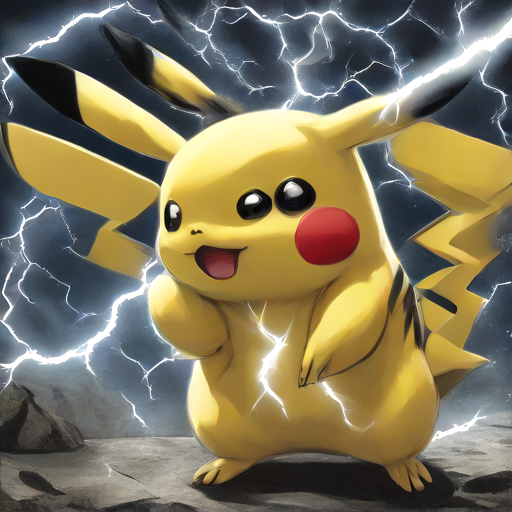

In electric hues, our Pikachu shines
   A furry friend, so full of life
   His lightning bolt tail, it never declines
   His electric charge, forever rife

   With ears so round, they're hard to miss
   And fur that's yellow, oh so bright
   Our Pikachu, he's truly bliss
   A Pokemon delight, in every sight

   We've captured him in art, so true
   His image, a masterpiece in hand
   Our Pikachu, forever anew
   In this digital world, he'll forever stand

   Our image, a testament to his might
   A Pikachu, so full of delight

   [Insert image here]

   Our Pikachu, so full of cheer
   His electric charge, forever near
   In this image, we've captured his flair
   Our Pikachu, forever so rare.




In [24]:
# Modify this prompt to generate different outputs
prompt = "Write a short poem about Pikachu with a picture."


response = openai.chat.completions.create(
    model=DEFAULT_LLM,
    messages=[{"role": "user", "content": prompt}],
    temperature=DEFAULT_TEMPERATURE,
    max_tokens=DEFAULT_MAX_TOKENS,
    top_p=DEFAULT_TOP_P,
    stream=False,
    extra_body={"system_message": SYSTEM_MESSAGE},
)
display_content(response.messages[1]["content"])

## Completion

[OpenAI API Reference](https://platform.openai.com/docs/api-reference/completions/create)


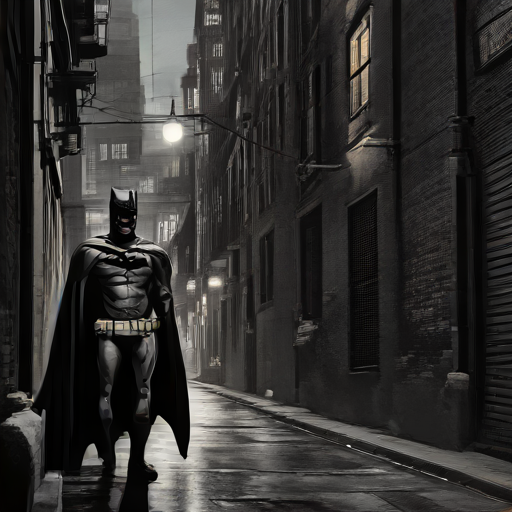

In the shadows of Gotham's night,
   A figure emerges from the gloom,
   His cape billowing in the breeze,
   The Batman comes to save the room.

   The Bat-Signal shines above the fray,
   A beacon calling out for help,
   The Caped Crusader answers its call,
   His mission to make justice prevail.

   The alleyway's grime and grit surround,
   But Batman's suit is sleek and strong,
   Its texture woven from threads of steel,
   A shield against Gotham's wrongs.

   The cowl conceals his face in shadow,
   But his eyes blaze with fierce intent,
   His heart beats with a warrior's fire,
   His spirit unbroken and unbent.

   The wind whips through his cape like a song,
   A symphony of justice and might,
   The Batman stands tall in Gotham's night,
   A symbol of hope in the darkest light.

   [Image: "Batman in G




In [25]:
# Modify this prompt to generate different outputs
prompt = "Write a short poem about batman with an accompanying image."

completion = openai.completions.create(
    model=DEFAULT_LLM,
    prompt=prompt,
    temperature=DEFAULT_TEMPERATURE,
    max_tokens=DEFAULT_MAX_TOKENS,
    top_p=DEFAULT_TOP_P,
    n=1,
    stream=False,
    extra_body={"system_message": SYSTEM_MESSAGE},
)
display_content(completion.choices[0].text)

## Cloning Text to Speech

Any `wav` file in the `voices` directory can be used as a voice.


In [26]:
prompt = "Write a short poem about Taco Bell's Doritos Locos Tacos."
response = requests.post(
    f"{EZLOCALAI_SERVER}/v1/audio/generation",
    headers=HEADERS,
    json={
        "text": prompt,
        "voice": "DukeNukem",
        "language": "en",
    },
)
audio_response = response.json()
display_content(audio_response["data"])

UklGRkaSAwBXQVZFZm10IBAAAAABAAEAwF0AAIC7AAACABAATElTVBoAAABJTkZPSVNGVA4AAABMYXZmNTguNzYuMTAwAGRhdGEAkgMA/v/2/wAACQAKAA8AEQAYABgAGwAeAB4AHQAeAB0AIgAjACkALgAwADAAMgA3ADYAMwA1ADQAMwAzADIALQAtAC0ALAAtACwAMAAsAC0ALQAwACwAKgAwAC4ALwAsAC0AKwAsACwAKwAqACgAKgAoACkAJwAqACUAIgAnACcAJQAiACYAHwAdACAAIwAkACAAIQAiACEAHwAgABMAFgAgAB4AHQAVABoAFgAcABwAHgAbABkAGwAdAB4AHAAXABkAGQAbACAAHAAbABkAGQAVABAAFQAXABUAHAAbABkAHwAbABQAFAASABcAEwAPABMADQAUABYAEQAMAAsAFQAOAA0ADgAMAAwACwAEAAUABQAIAAcAAwAHAP////8GAAcACQADAAAA///+/wUABQALAAIABQAGAPr///8FAPf/BwAFAP7/+v8BAP////8EAAIAAAD+//n/9v/0//r////6//n//P8CAPX/+v/3//H/9f/5//X/7//t//H/+P/v//L/8f/z//H/+P/8//r/9//6//j/9//5//b/9f/6//z//f8BAPz//v/8//j/+P/0//f/9//6//T/+P/+//f//f/3//////////z/BgADAP//AQABAP//8v/5//n/9v/w//T/8v/6//3/AAD8//j/+/8AAAAAAQAIAAcABgAKABIADgARABUAGgAVABcAGAAcACYAHgAiABwAIQAqACUAHQAeABoAEgAaACcAHwAzAC0AMgA2ADgAPgA3AEAAQwBEAEsASQBEADcAPABCADwAOQBAAEAAQQBBAE0ASQBNAEYATABVAFcAWABZAFQATABEADsAQQA1AEIAOABEAD8APgAwAC4AJgAuACwAIwAoACMAGAATABIADwAfAA8AHgAGAAgA

## Text to Speech


In [27]:
# We will use the audio response from the previous cell to transcribe it.
transcription = requests.post(
    f"{EZLOCALAI_SERVER}/v1/audio/transcriptions",
    json={
        "file": audio_response["data"],
        "audio_format": "wav",
        "model": "base",
    },
    headers=HEADERS,
)


print(transcription.json())

{'data': " Write a short poem about Taco Bell's Doritos, Locos Tacos."}


## Voice Completion Example


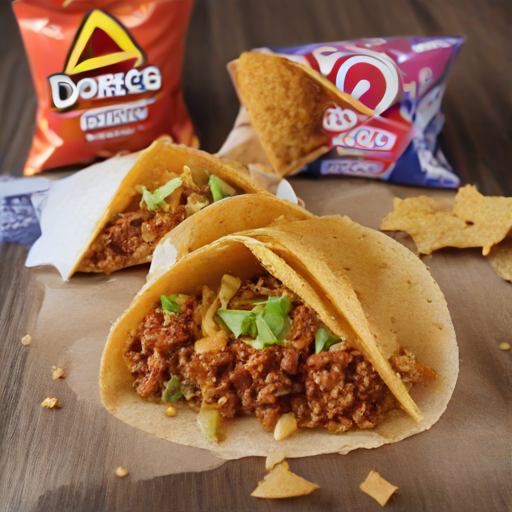

Crispy shell, filled with meat,
   Doritos crunch, a spicy treat,
   Cheese and sour cream, a perfect blend,
   Taco Bell's Doritos, Locos Tacos, my friend.
   
   Bite into the crunchy shell,
   Taste the Doritos, so surreal,
   The flavors dance, in perfect harmony,
   Taco Bell's Doritos, Locos Tacos, my melody.
   
   The spices ignite, a fiery blaze,
   The image before me, a sight to behold,
   A crispy shell, filled with meat,
   Doritos crunch, a spicy treat,
   Cheese and sour cream, a perfect blend,
   Taco Bell's Doritos, Locos Tacos, my friend.
   
   The image captures it all,
   The colors vibrant, the details small,
   The Doritos crunch, so crisp and bold,
   Taco Bell's Doritos, Locos Tacos, my story told.
   
   Bite into the crunch
http://localhost:8091/outputs/184513796b2647b992da175601589843.wav




In [34]:
# We will use the audio response from a couple of cells back.
completion = openai.completions.create(
    model=DEFAULT_LLM,
    prompt=audio_response["data"],
    temperature=DEFAULT_TEMPERATURE,
    max_tokens=DEFAULT_MAX_TOKENS,
    top_p=DEFAULT_TOP_P,
    n=1,
    stream=False,
    extra_body={
        "system_message": SYSTEM_MESSAGE,
        "audio_format": "wav",
        "voice": "DukeNukem",
    },
)

response_text = completion.choices[0].text
display_content(response_text)